In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import signal, linalg
from ipywidgets import interact

In [2]:
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
%reload_ext timedomainfit
from timedomainfit import *
import timedomainfit as td

In [228]:
mpl.rc('font', size='9')

In [3]:
# phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = td.make_optfunc(t0=0, tp=1.4e-3)

In [4]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [5]:
b = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False)

100%|██████████| 784/784 [00:07<00:00, 101.30it/s]
1500it [00:00, 2528.78it/s]


Response:
f   mag       dB
    0.000 1.000    0.000
 3091.925 0.983   -0.152
 6183.850 0.927   -0.658
24735.399 0.095  -20.423
30919.249 0.011  -38.978
49470.798 0.000 -101.893
61838.498 0.000 -110.800
500000.000 0.000 -339.063


In [6]:
p0 = np.array([-23, 30, 61.850, 0.01, 0.0])
bdamp = fit_damped_sine_eliminate_harmonics(b.t_ms, b.x, p0)

In [7]:
b2 = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False)

100%|██████████| 784/784 [00:07<00:00, 101.17it/s]
2900it [00:01, 2743.61it/s]

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.589 0.983   -0.152
 6183.178 0.927   -0.658
24732.713 0.095  -20.422
30915.891 0.011  -38.973
49465.425 0.000 -101.894
61831.782 0.000 -110.805
500000.000 0.000 -354.967


In [8]:
remove_harmonics(b2, bdamp)

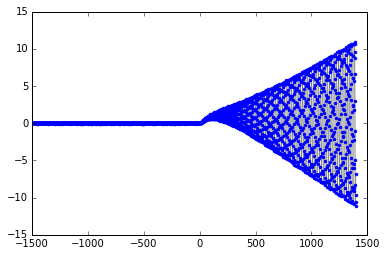

In [9]:
t = b2.t_us
plt.plot(t, b2.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, b2.resid, '.',)

In [10]:
bi = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False, align_voltage=True)

100%|██████████| 784/784 [00:05<00:00, 155.50it/s]
1500it [00:00, 2888.71it/s]

Response:
f   mag       dB
    0.000 1.000   -0.000
 3099.931 0.983   -0.152
 6199.861 0.927   -0.660
24799.444 0.096  -20.369
30999.305 0.011  -38.830
49598.888 0.000 -101.957
61998.610 0.000 -110.975
500000.000 0.000 -179.337


In [11]:
bidamped = fit_damped_sine_eliminate_harmonics(bi.t_ms, bi.x, p0=np.array([0, 0, 62.0, 0.0, 0.0]))

In [12]:
bi_all = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False, align_voltage=True)

100%|██████████| 784/784 [00:04<00:00, 158.06it/s]
2900it [00:01, 2887.39it/s]

Response:
f   mag       dB
    0.000 1.000   -0.000
 3096.811 0.983   -0.152
 6193.623 0.927   -0.661
24774.492 0.096  -20.354
30968.115 0.011  -38.789
49548.983 0.000 -101.976
61936.229 0.000 -111.030
500000.000 0.000 -179.312


In [13]:
remove_harmonics(bi_all, bidamped)

(-1.51, -1.4)

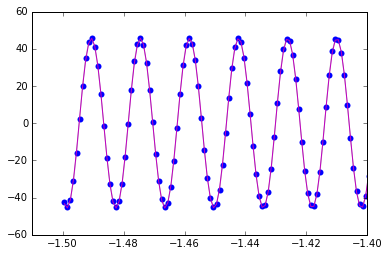

In [14]:
plt.plot(bi.t_ms, bi.x, color='0.5', alpha=0.5)
plt.plot(bi.t_ms, bi.x, 'o', markeredgewidth=0)
plt.plot(bi.t_ms, bidamped.fit0.x, 'm')
plt.xlim(-1.51, -1.4)

(-1.2, 4.6)

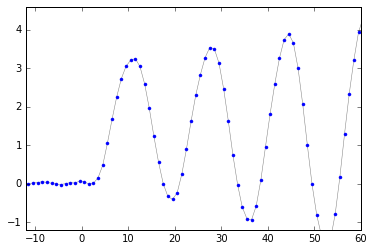

In [15]:
t = bi_all.t_us
plt.plot(t, bi_all.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, bi_all.resid, '.',)
plt.xlim(-12, 60)
plt.ylim(-1.2, 4.6)

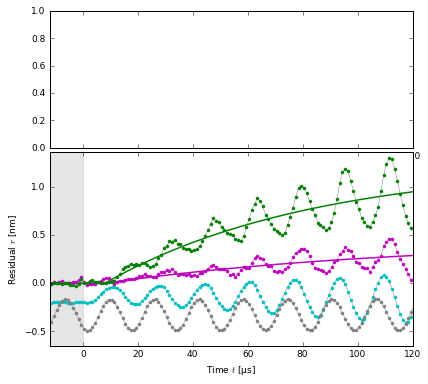

In [250]:
t = bi_all.t_us
# plt.plot(t, bi_all.resid, '-', linewidth=0.5, color='0.5')
# plt.plot(t, bi_all.resid, '.',)
fig = plt.figure(figsize=(6.5, 6))
gs = mpl.gridspec.GridSpec(12, 1)
ax1 = fig.add_subplot(gs[:5])


ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[5:])

ax2.plot(t, bi_all.resid*0.05-0.2, '-', linewidth=0.5, color='0.5')
ax2.plot(t, bi_all.resid*0.05-0.2, '.', color='c')

ax2.plot(t, b1s_all.resid, '-', linewidth=0.5, color='0.5')
ax2.plot(t, b1s_all.resid, '.', color='m')

m = pk.masklh(b1s_all.t_us, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt1, pcov1 = optimize.curve_fit(dc, b1s_all.t_us[m], b1s_all.resid[m],
                                  p0=np.array([0.3, 60]))
# plt.plot(t, dc(t, 0.3, 60), 'm', linewidth=1.5, zorder=0)
plt.plot(t, dc(t, 0.4433, 106.6), 'm', linewidth=1.5, zorder=0)

plt.axvspan(-12, 0, color='0.8', zorder=0, alpha=0.5)

t = b2.t_us

plt.plot(t, b2.x_no_overtones*0.004-0.33, '.', color='0.5')
plt.plot(t, b2.x_no_overtones*0.004-0.33, '-', color='0.5', alpha=0.5)

plt.plot(t, b2.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, b2.resid, 'g.',)
m = pk.masklh(t, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt, pcov = optimize.curve_fit(dc, t[m], b2.resid[m],
                                p0=np.array([1, 20]))
plt.plot(t, dc(t, *popt), 'g', linewidth=1.5, zorder=0)
plt.xlim(-12, 120)
plt.ylim(-0.65, 1.36)
plt.ylabel('Residual $r$ [nm]')
plt.xlabel(u"Time $t$ [µs]")
plt.savefig('../../figs/SI-151-residuals.pdf', bbox_inches='tight')

In [122]:
def dc_term(t_, tau, t0, dx):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    x_light =(dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    return np.where(t > 0, x_light, 0)

In [135]:
bdamp.fit.popt[:2]

array([-22.55085516,  34.68686629])

In [159]:
def dc_plus_ac(t_, tau, t0, dx, X0, Y0, tau_df):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    phi = pk.phase_step(t, tau_df, 1)
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    x_df = X0 * phi * np.cos(t*omega) + Y0 * phi * np.sin(t*omega)
    return np.where(t > 0, x_light + x_df, 0)

In [293]:
def dc_induced_ac(t_, tau, t0, dx, X0, Y0, tau_df):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    return - dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))

In [160]:
m = pk.masklh(b2.t_us, -10, 180)
popt, pcov = optimize.curve_fit(dc_term, b2.t_ms[m], b2.resid[m], p0=np.array([0.050, 0.008, 1.4]))

In [162]:
popt2, pcov2 = optimize.curve_fit(dc_plus_ac, b2.t_ms[m], b2.resid[m], p0=np.r_[0.05, 0.008, 0.7, 0, 0, 0.05])

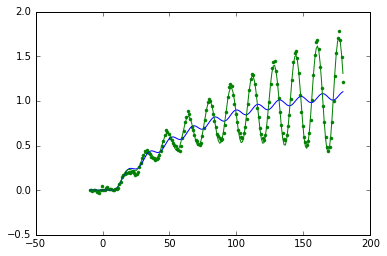

In [176]:
plt.plot(b2.t_us[m], b2.resid[m], 'g.')
plt.plot(b2.t_us[m], dc_term(b2.t_ms[m], *popt2[:3]))
plt.plot(b2.t_us[m], dc_plus_ac(b2.t_ms[m], *popt2))
# plt.plot(b2.t_us[m], b2.resid[m] - dc_term(b2.t_us[m], *popt))
# plt.plot(b2.t_us[m], 0.001 * pk.phase_step(b2.t_us[m], 50, 10) * np.cos(b2.t_us[m]))

In [215]:
A0 = abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j)

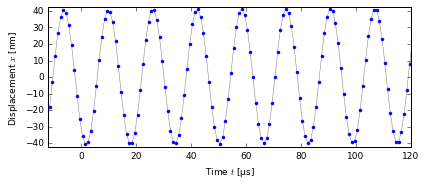

In [247]:
plt.figure(figsize=(6.5, 2.5))
plt.plot(b2.t_us, b2.x_no_overtones, linewidth=0.5, color='0.5')
plt.plot(b2.t_us, b2.x_no_overtones, '.')
plt.xlim(-12, 120)
plt.ylim(-42.2, 42.2)
plt.xlabel(u"Time $t$ [µs]")
plt.ylabel(u'Displacement $x$ [nm]')
plt.savefig('../../figs/SI-150-x-vs-t.pdf', bbox_inches='tight')

In [248]:
!open '../../figs/SI-150-x-vs-t.pdf'

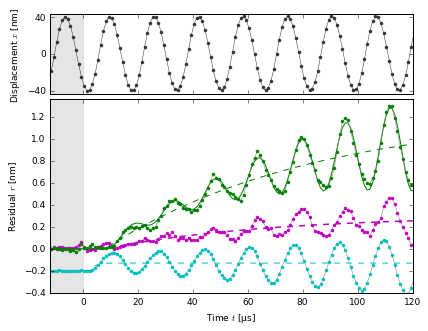

In [282]:
t = bi_all.t_us
# plt.plot(t, bi_all.resid, '-', linewidth=0.5, color='0.5')
# plt.plot(t, bi_all.resid, '.',)
fig = plt.figure(figsize=(6.5, 5))
gs = mpl.gridspec.GridSpec(10, 1)
ax1 = fig.add_subplot(gs[:3])

ax1.axvspan(-12, 0, color='0.8', zorder=0, alpha=0.5)

ax1.plot(b2.t_us, b2.x, linewidth=0.5, color='0.2')
ax1.plot(b2.t_us, b2.x, '.', color='0.2')

plt.xlim(-12, 120)
plt.ylim(-44, 44)
ax1.set_yticks(np.arange(-40, 41, 40))
plt.xlabel(u"Time $t$ [µs]")
plt.ylabel(u'Displacement $x$ [nm]')

ax2 = fig.add_subplot(gs[3:])

ax2.plot(t, bi_all.resid*0.05-0.2, '-', linewidth=0.5, color='0.5')
ax2.plot(t, bi_all.resid*0.05-0.2, '.', color='c')

ax2.plot(t, b1s_all.resid, '-', linewidth=0.5, color='0.5')
ax2.plot(t, b1s_all.resid, '.', color='m')

m = pk.masklh(b1s_all.t_us, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt1, pcov1 = optimize.curve_fit(dc, b1s_all.t_us[m], b1s_all.resid[m],
                                  p0=np.array([0.3, 60]))

# ax2.plot(b2.t_us[m], dc_term(b2.t_ms[m], *popt2[:3]))
# ax2.plot(b2.t_us[m], dc_term(b2.t_ms[m], *popt2[:3]))
# ax2.plot(b2.t_us[m], dc_plus_ac(b2.t_ms[m], *popt2))

ax2.plot(b2.t_us[m], dc_plus_ac(b2.t_ms[m], *popt2), color='g')
plt.plot(t, dc(t, 0.3, 60), 'm--', linewidth=1.5, zorder=0)
# plt.plot(t, dc(t, 0.4433, 106.6), 'm--', linewidth=1, zorder=0)

plt.axvspan(-12, 0, color='0.8', zorder=0, alpha=0.5)

t = b2.t_us

# plt.plot(t, b2.x_no_overtones*0.004-0.33, '.', color='0.5')
# plt.plot(t, b2.x_no_overtones*0.004-0.33, '-', color='0.5', alpha=0.5)

plt.plot(t, b2.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, b2.resid, 'g.',)
m = pk.masklh(t, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt, pcov = optimize.curve_fit(dc, t[m], b2.resid[m],
                                p0=np.array([1, 20]))
plt.plot(t, dc(t, *popt), 'g--', linewidth=1, zorder=0)
plt.plot(t, dc(t+5, 0.07, 1.5) - 0.2, 'c--', linewidth=1)
plt.xlim(-12, 120)
plt.ylim(-0.4, 1.36)
plt.ylabel('Residual $r$ [nm]')
plt.xlabel(u"Time $t$ [µs]")
ax1.set_xticklabels([''])

fig.savefig('../../figs/SI-151-residuals.pdf', bbox_inches='tight')

In [277]:
!open ../../figs/SI-151-residuals.pdf

In [283]:
!cp ../../figs/SI-151-residuals.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/SI/

In [287]:
popt2 * np.array([1e3, 1e3, 1, 1, 1, 1e3])

array([ 69.32406869,   6.62656194,   1.15723073,  -4.30244196,
         0.25325448,  18.10830578])

In [179]:
-4.30244196 + 0.25325448 * 1j

(-4.30244196+0.25325448j)

In [286]:
popt2

array([ 0.06932407,  0.00662656,  1.15723073, -4.30244196,  0.25325448,
        0.01810831])

In [ ]:
pcov2

In [181]:
bdamp.fit.popt[:2]

array([-22.55085516,  34.68686629])

In [183]:
bdamp.fit.x[-1]

-25.558878095447959

In [290]:
(pcov2.diagonal() ** 0.5)  * np.array([1e3, 1e3, 1, 1, 1, 1e3]) * 2

array([ 3.81756885,  0.88636373,  0.0244723 ,  0.29625414,  1.48688985,
        8.63607003])

In [326]:
bdamp.fit.popt * np.array([1, 1, 1e3, 1, 1])

array([ -2.25508552e+01,   3.46868663e+01,   6.18405089e+04,
         8.84332108e-03,  -9.63682313e-02])

In [338]:
Q = bdamp.fit.popt[2]*np.pi/(bdamp.fit.popt[3])

In [340]:
Q

21968.860660353155

In [341]:
6.62119637469e-06 * 1e3

0.00662119637469

In [342]:
for i in (bdamp.fit.pcov.diagonal() ** 0.5):
    print(i*2)

0.00297526408465
0.0029799402396
1.32423927494e-05
8.36400592223e-05
0.00104980008186


In [339]:
(4.18200296112e-05 / 8.84332108e-03) * Q

103.89065318663017

In [327]:
for i in bdamp.fit.popt:
    print(i)

-22.5508551568
34.6868662884
61.8405089394
0.00884332107987
-0.0963682312709


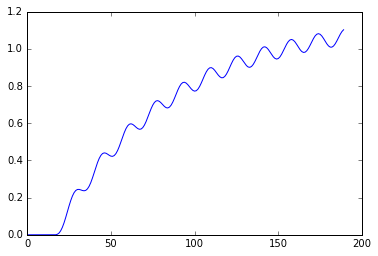

In [171]:
plt.plot(dc_term(b2.t_ms[m], 69.32406869e-3,   6.62656194e-3,   1.15723073))

In [110]:
li_resid = lockin.LockIn(b2.t, b2.resid, 1e6)
li_resid.lock2()
li_resid.phase(ti=0)

Response:
f   mag       dB
    0.000 1.000    0.000
 3092.783 0.983   -0.152
 6185.567 0.927   -0.658
24742.267 0.095  -20.428
30927.834 0.011  -38.989
49484.534 0.000 -101.888
61855.668 0.000 -110.788
500000.000 0.000 -344.710


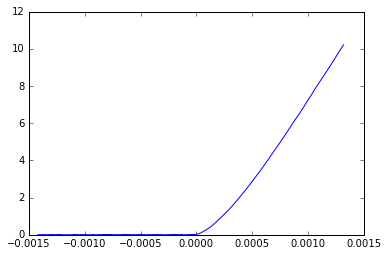

In [112]:
plt.plot(li_resid('t'), li_resid('A'))

(-200, 3000)

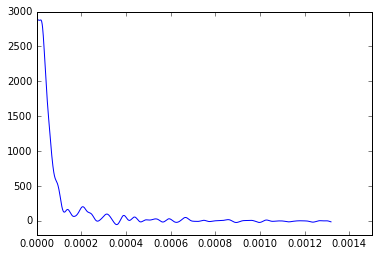

In [121]:
plt.plot(li_resid('t'), li_resid('df'))
plt.xlim(0, 0.0015)
plt.ylim(-200, 3000)

In [101]:
popt

array([  1.23172388,  75.78435184])

In [90]:
1.28 / 3.5

0.3657142857142857

In [18]:
b2.resid

array([ -2.81324359e-02,  -2.28593462e-02,  -3.27315458e-03, ...,
        -1.11127816e+01,  -9.69685386e+00,  -6.76375842e+00])

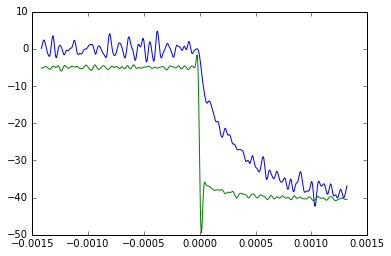

In [19]:
plt.plot(b2.li('t'), b2.li('df'))
plt.plot(bi_all.li('t'), bi_all.li('df')*0.25-5)

In [20]:
reload(td)

<module 'timedomainfit' from 'timedomainfit.pyc'>

In [31]:
bi_all.fit_all = td.record_fit(td.damped_sine_exp, bi.t_ms, bi.x, p0=np.array([40, 0, 62.0, 0, 0, -0.12, 10.0, 0.0]))

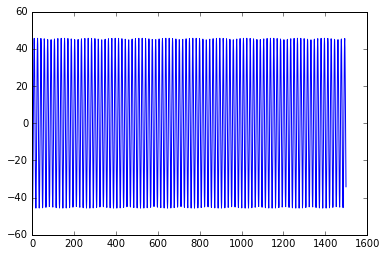

In [32]:
plt.plot(bi.fit_all.x)

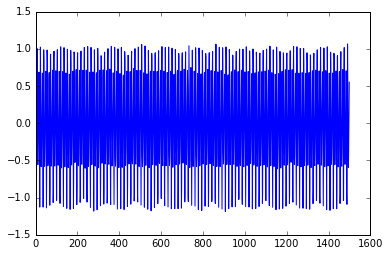

In [33]:
plt.plot(bi_all.fit_all.resid)

In [34]:
A = td.harNphi(td._damped_sine_exp_phi(bi_all.t_ms, *bi_all.fit_all.popt),
            5,
            td._damped_sine_exp_A(bi_all.t_ms, *bi_all.fit_all.popt)
            )

In [35]:
bi_all.x_har, _, __, ___ = linalg.lstsq(A, bi_all.fit_all.resid)

ValueError: incompatible dimensions

In [36]:
bi_all.fit_all = td.record_fit(td.damped_sine_exp, bi_all.t_ms, bi_all.x, p0=np.array([40, 0, 62.0, 0, 0, -0.12, 10.0, 0.0]))

(-6, 10)

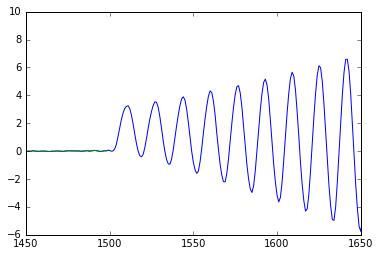

In [37]:
plt.plot(bi_all.resid)
plt.plot(bidamped.fit.resid)
plt.xlim(1450, 1650)
plt.ylim(-6, 10)

In [38]:
bi_all.fit_all.popt

array([ -3.99027745e+01,  -2.36796232e+01,   6.19989141e+01,
        -1.63114950e-02,   9.30508604e-02,  -1.38910080e-01,
         2.96825971e+02,  -1.73898227e-02])

In [39]:
td.damped_sine_exp(bi_all.t_ms, *np.array([-4.32917325e+01,  -1.44660161e+01,   6.19986306e+01,
        -2.43226565e-04,  -8.79504450e-04, 0, 0, 0]))

array([-45.36469279, -43.82830267, -35.72485072, ...,  38.08689252,
        25.68032749,   9.42571477])

In [40]:
td.damped_sine_exp(bi_all.t_ms, *bi_all.fit_all.popt)

array([-42.83801124, -45.08760234, -40.56726905, ...,  31.58833294,
        42.73567736,  47.52194947])

In [41]:
fh2 = h5py.File("../../data/tr-efm/151217-234238-20sun-df-384.h5", "r")
b1s = td.signal_average_gr_parab(fh2['data'], -1.5e-3, 0, invert=False)

100%|██████████| 384/384 [00:03<00:00, 101.42it/s]
1500it [00:00, 2654.08it/s]

Response:
f   mag       dB
    0.000 1.000    0.000
 3092.013 0.983   -0.152
 6184.027 0.927   -0.658
24736.106 0.095  -20.424
30920.133 0.011  -38.979
49472.212 0.000 -101.892
61840.265 0.000 -110.799
500000.000 0.000 -352.516


In [46]:
b1sdamped = td.fit_damped_sine_eliminate_harmonics(b1s.t_ms, b1s.x, p0=np.array([0, 0, 61.85, 0.01, 0.0]))

In [47]:
b1sdamped.fit.popt

array([ -2.38997134e+01,   3.53339373e+01,   6.18423233e+01,
         8.32346256e-03,  -9.84264299e-02])

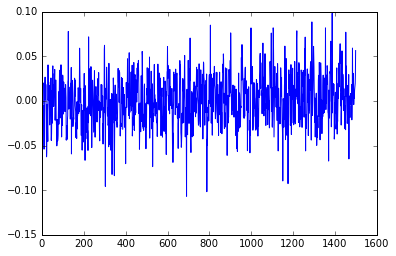

In [48]:
plt.plot(b1sdamped.fit.resid)

In [49]:
fh2 = h5py.File("../../data/tr-efm/151217-234238-20sun-df-384.h5", "r")
b1s_all = td.signal_average_gr_parab(fh2['data'], -1.5e-3, 1.4e-3, invert=False)

100%|██████████| 384/384 [00:03<00:00, 103.30it/s]
2900it [00:00, 3148.31it/s]

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.919 0.983   -0.152
 6183.837 0.927   -0.658
24735.349 0.095  -20.423
30919.187 0.011  -38.977
49470.699 0.000 -101.893
61838.373 0.000 -110.800
500000.000 0.000 -337.083


In [50]:
remove_harmonics(b1s_all, b1sdamped)

(-0.1, 0.5)

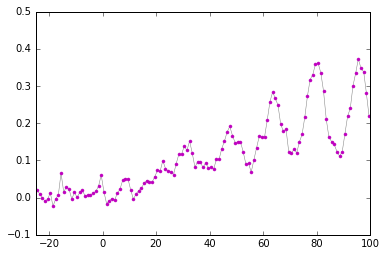

In [62]:
plt.plot(t, b1s_all.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, b1s_all.resid, '.', color='m')
plt.xlim(-25, 100)
plt.ylim(-0.1, 0.5)

In [63]:
pk.phase_step(0.1, 0.1, 20)

0.73575888234288467

(0, 100)

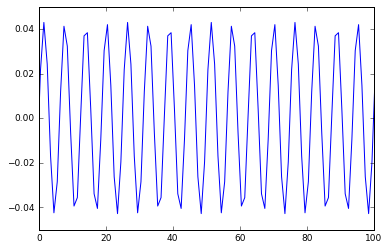

In [295]:

plt.plot(t,  dc_induced_ac(t, *popt2))
plt.xlim(0, 100)

In [301]:
omega_tau = (popt2[0] * (2*np.pi*bdamp.fit.popt[2]))

In [306]:
abs((1 + 1j * omega_tau) / bdamp.fit.popt[2]) * 

0.0370991497846685

In [309]:
(1/np.sqrt(1 + omega_tau**2) * 1.16) / 42

0.0010246431845289394

In [321]:
(popt2[2]/np.sqrt(1 + omega_tau**2)) / abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j) / (2*np.pi) * 1e3

0.16515347453976778

In [323]:
(popt2[2]/np.sqrt(1 + omega_tau**2))

0.042932276282298815

In [322]:
0.165 * 0.058

0.00957

In [313]:
abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j)

41.372935129315046

In [318]:
sum(bdamp.fit.pcov[:2, :2].diagonal())**0.5

0.0021054833296064055

In [319]:
4/69

0.057971014492753624